In [31]:
using Plots
using LinearAlgebra

**Basic function definition**

In [32]:
function fourierSeries(coefficients::Vector{Float64}, domain::Vector{Float64}, L::Real)::Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}}
	
    N = length(coefficients) - 1
	n_domain = length(domain)
	
    S = zeros(Float64, n_domain)
    Sz = zeros(Float64, n_domain)
    Szz = zeros(Float64, n_domain)
    Szzz = zeros(Float64, n_domain)
    Szzzz = zeros(Float64, n_domain)

	# Add constant offset to S
	S .= coefficients[1] 
	
	# Pre-allocate buffers for trig values to avoid recomputation
	cos_kz = Vector{Float64}(undef, n_domain)
	sin_kz = Vector{Float64}(undef, n_domain)
	
	π_over_L = π / Float64(L)  # Compute once and ensure Float64
	
	for n in 1:N
		k = n * π_over_L  # Compute inline, no array allocation
		coeff = coefficients[n + 1]
		
		# Compute trig values once, reuse for all derivatives
		@. cos_kz = cos(k * domain)
		@. sin_kz = sin(k * domain)
		
		@. S += coeff * cos_kz
		@. Sz -= k * coeff * sin_kz
		@. Szz -= (k^2) * coeff * cos_kz
		@. Szzz += (k^3) * coeff * sin_kz
		@. Szzzz += (k^4) * coeff * cos_kz
	end
		
    return S, Sz, Szz, Szzz, Szzzz
end

fourierSeries (generic function with 1 method)

## Test: Zero-padding (oversampling) effect on nonlinear products

We'll compare evaluating the Fourier series on:
1. Base grid (2N+2 points)
2. Oversampled grid (2× density)

Goal: see how oversampling reduces aliasing in nonlinear products.


**Step 1: Create Fourier coefficients with exponential decay**


First 10 coefficients: [1.0, 0.2, 0.04000000000000001, 0.008000000000000002, 0.0016000000000000005, 0.0003200000000000001, 6.400000000000002e-5, 1.2800000000000006e-5, 2.5600000000000013e-6, 5.120000000000002e-7]


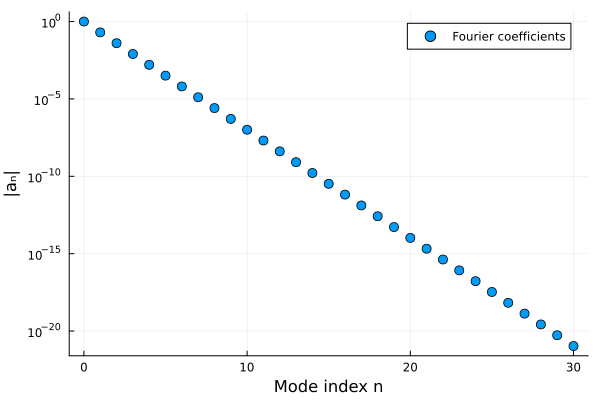

In [33]:
# Parameters
N = 30  # number of modes
L = π   # half-domain length

# Create coefficients: a0=1.0, a1=0.2, then exponential decay
coeffs = zeros(Float64, N+1)
coeffs[1] = 1.0    # a0 (constant term)
coeffs[2] = 0.2    # a1 = 0.2 (starting amplitude)

# Exponential decay from a1 onwards: aₙ = a₁ * decay_rate^(n-1) for n ≥ 1
decay_rate = 0.2
for n in 2:N
    coeffs[n+1] = coeffs[2] * (decay_rate)^(n-1)
end

println("First 10 coefficients: ", coeffs[1:10])

# Plot coefficients on log scale - should show straight line for exponential decay
scatter(0:N, abs.(coeffs), yscale=:log10, xlabel="Mode index n", ylabel="|aₙ|", 
        label="Fourier coefficients", marker=:circle, ms=5, legend=:topright)

**Step 2: Set up base and oversampled domains**


In [34]:
# Base domain: 2N+2 points between -L and L
dz = 2*L / (2*N+1)
z = collect(-L:dz:L)
println("Base grid: ", length(z), " points, dz = ", dz)

# Oversampled domain: 2× density (half the spacing)
pad_factor = 2.0
dz_pad = dz / pad_factor
z_pad = collect(-L:dz_pad:L)
println("Oversampled grid: ", length(z_pad), " points, dz_pad = ", dz_pad)

Base grid: 62 points, dz = 0.10300303782261616
Oversampled grid: 123 points, dz_pad = 0.05150151891130808


**Step 3: Compute S and derivatives on both grids**


In [35]:
# Evaluate on base grid
S, Sz, Szz, Szzz, Szzzz = fourierSeries(coeffs, z, L)
println("Computed S and derivatives on base grid")

# Evaluate on oversampled grid (same coefficients, denser sampling)
S_pad, Sz_pad, Szz_pad, Szzz_pad, Szzzz_pad = fourierSeries(coeffs, z_pad, L)
println("Computed S and derivatives on oversampled grid")


Computed S and derivatives on base grid
Computed S and derivatives on oversampled grid


**Step 4: Plot S and all derivatives**


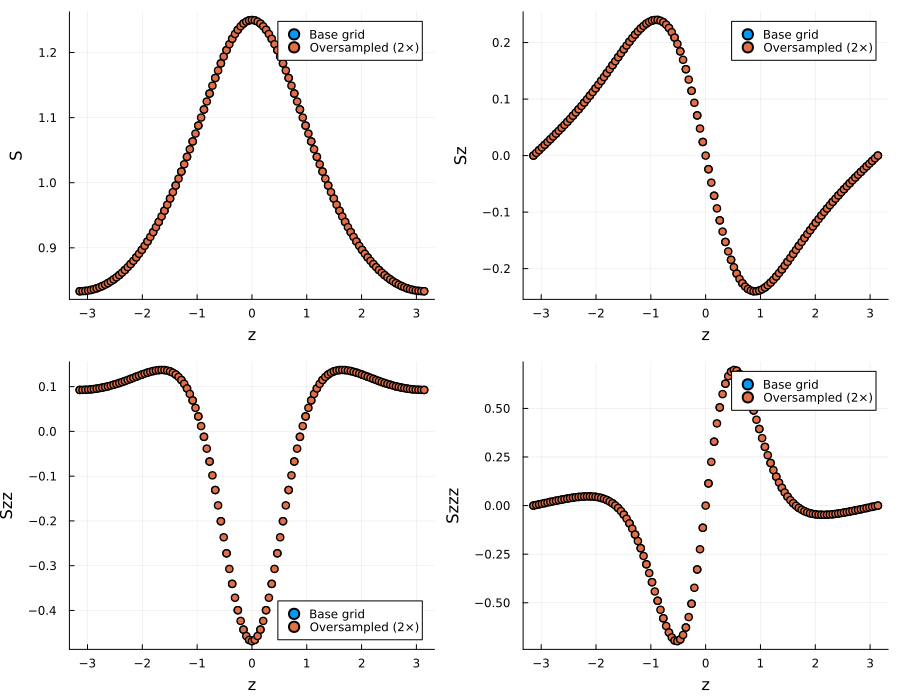

In [36]:
p1 = scatter(z, S, label="Base grid", lw=2, xlabel="z", ylabel="S", legend=:topright)
scatter!(p1, z_pad, S_pad, label="Oversampled (2×)", lw=2)

p2 = scatter(z, Sz, label="Base grid", lw=2, xlabel="z", ylabel="Sz")
scatter!(p2, z_pad, Sz_pad, label="Oversampled (2×)", lw=2)

p3 = scatter(z, Szz, label="Base grid", lw=2, xlabel="z", ylabel="Szz")
scatter!(p3, z_pad, Szz_pad, label="Oversampled (2×)", lw=2)

p4 = scatter(z, Szzz, label="Base grid", lw=2, xlabel="z", ylabel="Szzz")
scatter!(p4, z_pad, Szzz_pad, label="Oversampled (2×)", lw=2)

plot(p1, p2, p3, p4, layout=(2,2), size=(900, 700))

**Step 5: Compute nonlinear products (where aliasing matters)**

These are the kinds of products that appear in the equations and where aliasing from insufficient sampling can cause errors.


In [37]:
# Nonlinear products on base grid
Szsq = 1 .+ Sz.^2
curvature = -Szz ./ (Szsq.^(3/2)) .+ 1 ./ (S .* sqrt.(Szsq))
sqrt_term = sqrt.(Complex.(Szsq))

# Nonlinear products on oversampled grid
Szsq_pad = 1 .+ Sz_pad.^2
curvature_pad = -Szz_pad ./ (Szsq_pad.^(3/2)) .+ 1 ./ (S_pad .* sqrt.(Szsq_pad))
sqrt_term_pad = sqrt.(Complex.(Szsq_pad))

println("Computed nonlinear products on both grids")


Computed nonlinear products on both grids


**Step 6: Plot nonlinear products comparison**

Key observation: Derivatives are identical on both grids (just sampled at different resolutions), but nonlinear products can show differences due to aliasing when computed on insufficient grids.


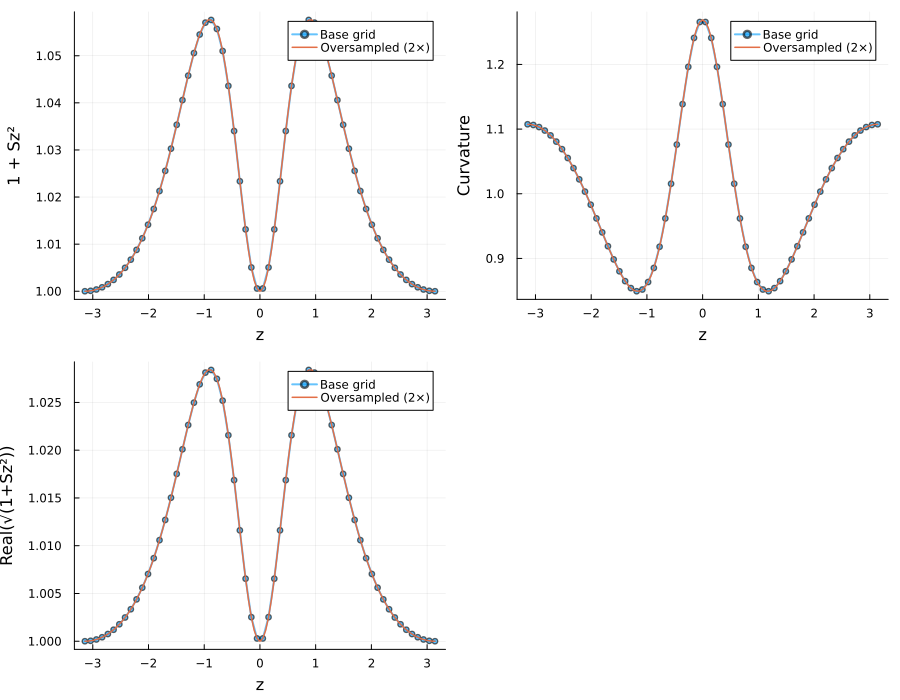

In [38]:
p1 = plot(z, Szsq, label="Base grid", lw=2, xlabel="z", ylabel="1 + Sz²", 
          legend=:topright, marker=:circle, ms=3, alpha=0.6)
plot!(p1, z_pad, Szsq_pad, label="Oversampled (2×)", lw=1.5, ls=:solid)

p2 = plot(z, curvature, label="Base grid", lw=2, xlabel="z", ylabel="Curvature", 
          marker=:circle, ms=3, alpha=0.6)
plot!(p2, z_pad, curvature_pad, label="Oversampled (2×)", lw=1.5, ls=:solid)

p3 = plot(z, real.(sqrt_term), label="Base grid", lw=2, xlabel="z", 
          ylabel="Real(√(1+Sz²))", marker=:circle, ms=3, alpha=0.6)
plot!(p3, z_pad, real.(sqrt_term_pad), label="Oversampled (2×)", lw=1.5, ls=:solid)

plot(p1, p2, p3, layout=(2,2), size=(900, 700))

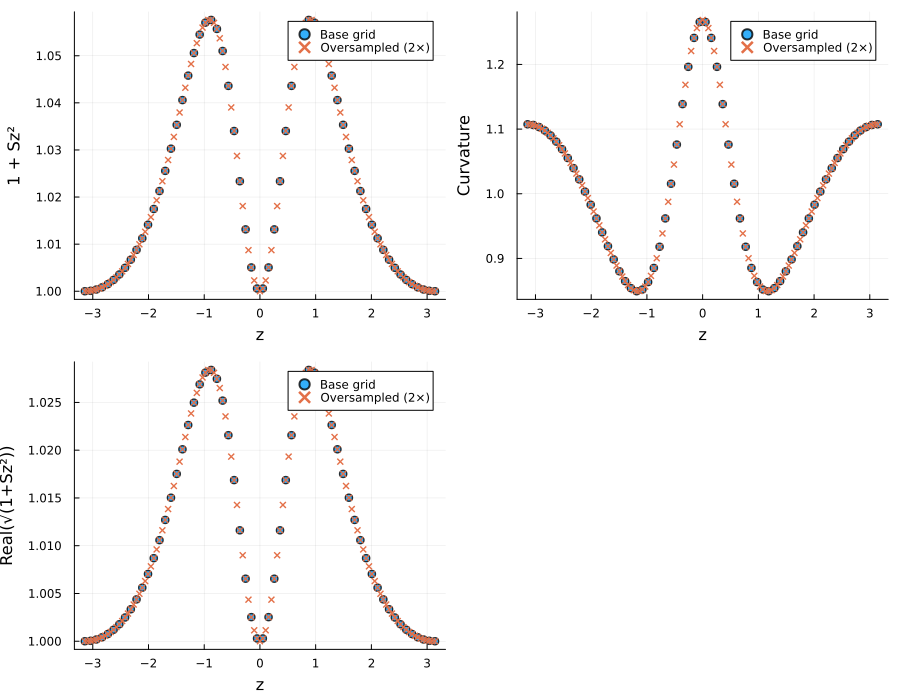

In [39]:
# Scatter plot version — all points drawn as markers, no connecting lines

p1 = scatter(z, Szsq, label="Base grid", 
             xlabel="z", ylabel="1 + Sz²", 
             legend=:topright, marker=:circle, ms=4, alpha=0.8)
scatter!(p1, z_pad, Szsq_pad, label="Oversampled (2×)", marker=:xcross, ms=3)

p2 = scatter(z, curvature, label="Base grid",
             xlabel="z", ylabel="Curvature",
             marker=:circle, ms=4, alpha=0.8)
scatter!(p2, z_pad, curvature_pad, label="Oversampled (2×)", marker=:xcross, ms=3)

p3 = scatter(z, real.(sqrt_term), label="Base grid",
             xlabel="z", ylabel="Real(√(1+Sz²))",
             marker=:circle, ms=4, alpha=0.8)
scatter!(p3, z_pad, real.(sqrt_term_pad), label="Oversampled (2×)", marker=:xcross, ms=3)

plot(p1, p2, p3, layout=(2,2), size=(900, 700))

## Interpretation

**What to look for:**
1. **Derivatives (S, Sz, etc.)**: The oversampled version should look smoother but follow the same curve — they're just different samplings of the same band-limited function.

2. **Nonlinear products**: 
   - On the base grid, you might see slight "wiggliness" or artifacts where the products aren't quite smooth
   - On the oversampled grid, these products are computed more accurately because there's no aliasing from undersampling
   - The markers on the base grid show where we're actually evaluating; the oversampled line shows the "truth"

**Why this matters for our solver:**
- When we form `Szsq = 1 + Sz²` and curvature terms in `equations.jl`, doing it on an oversampled grid reduces numerical noise
- This improves the accuracy of the integrals and the conditioning of the Jacobian
- Cost: ~2× more points in intermediate calculations, but same number of unknowns (N modes)


In [44]:
# simple trapezoid for possibly nonuniform z
trapz(z, f) = sum((z[2:end] .- z[1:end-1]) .* (f[2:end] .+ f[1:end-1])) / 2

# cosine projections of f onto modes n=1..M
function cosine_projections(z, f, L, M)
    c = zeros(Float64, M)
    for n in 1:M
        k = n * π / L
        c[n] = trapz(z, f .* cos.(k .* z)) / L   # 1/L factor keeps scale consistent
    end
    return c
end

# pick a representative nonlinear product (you can also use curvature)
P_base = 1 .+ Sz.^2
P_pad  = 1 .+ Sz_pad.^2

M = N ÷ 2  # project a subset of modes (like we do in equations)
c_base = cosine_projections(z, P_base, L, M)
c_pad  = cosine_projections(z_pad, P_pad, L, M)

rel_inf = maximum(abs.(c_pad .- c_base)) / max(1e-16, maximum(abs.(c_pad)))
rel_l2  = norm(c_pad .- c_base) / max(1e-16, norm(c_pad))

println("projection rel_inf = ", rel_inf)
println("projection rel_l2  = ", rel_l2)

projection rel_inf = 1.5266659030704766e-14
projection rel_l2  = 1.3344084879560268e-14


In [52]:
N = 40; L = π
coeffs = zeros(Float64, N+1); coeffs[1]=1.0; coeffs[2]=0.5
decay_rate = 0.98
for n in 2:N
    coeffs[n+1] = coeffs[2]*(decay_rate)^(n-1)
end
# reuse your z, z_pad, fourierSeries, curvature, cosine_projections...
M = N
c_base = cosine_projections(z, curvature, L, M)
c_pad  = cosine_projections(z_pad, curvature_pad, L, M)
rel_inf = maximum(abs.(c_pad .- c_base)) / maximum(abs.(c_pad))
rel_l2  = norm(c_pad .- c_base) / norm(c_pad)
println(rel_inf, "  ", rel_l2)

4.859352239761512e-8  4.59001199371118e-8


In [53]:
# project curvature onto many modes using oversampled grid
Mhi = 3N
c_hi = cosine_projections(z_pad, curvature_pad, L, Mhi)

energy_total = norm(c_hi)^2
energy_aboveN = norm(c_hi[N+1:end])^2
println("high-mode energy fraction = ", energy_aboveN / energy_total)

high-mode energy fraction = 0.49927741267273795
